# Notebook 4: Evaluation & LDA Baseline

## 1. Setup

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pavannn16/BERTopic-arXiv-Analysis/blob/main/notebooks/04_evaluation.ipynb)

---

**Purpose:** Compute coherence, diversity, and compare with LDA baseline.

**Time:** ~5 minutes

In [1]:
# Install required packages
%pip install bertopic gensim scikit-learn pandas numpy plotly pyyaml -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ============================================================
# PROJECT SETUP - Config-based with Train/Infer Modes
# ============================================================
import os
import yaml
from pathlib import Path

# Clone repo if running on Colab
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/BERTopic-arXiv-Analysis'):
    !git clone https://github.com/pavannn16/BERTopic-arXiv-Analysis.git /content/BERTopic-arXiv-Analysis

# Load configuration
def load_config():
    config_paths = ['config.yaml', '../config.yaml', '/content/BERTopic-arXiv-Analysis/config.yaml']
    for path in config_paths:
        if os.path.exists(path):
            with open(path, 'r') as f:
                return yaml.safe_load(f), path
    return None, None

config, config_path = load_config()
if config:
    print(f"Loaded config from {config_path}")
else:
    config = {'mode': 'infer'}

MODE = config.get('mode', 'infer')
print(f"Mode: {MODE.upper()}")

# Setup paths - simplified for GitHub repo usage
if 'google.colab' in str(get_ipython()):
    PROJECT_PATH = '/content/BERTopic-arXiv-Analysis'
    print("Using cloned GitHub repo")
else:
    PROJECT_PATH = str(Path(os.getcwd()).parent) if 'notebooks' in os.getcwd() else os.getcwd()
    print("Running locally")

for folder in ['data/raw', 'data/processed', 'data/embeddings', 'models', 'results']:
    os.makedirs(f'{PROJECT_PATH}/{folder}', exist_ok=True)

print(f"Project path: {PROJECT_PATH}")

Loaded config from ../config.yaml
Mode: INFER
Running locally
Project path: /Users/pavan/Downloads/CSULA SEM1/AI/Code Assignments/BERTopic-arXiv-Analysis


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import json
from collections import Counter

# BERTopic
from bertopic import BERTopic

# Evaluation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.metrics import silhouette_score

# LDA baseline
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

print("Libraries imported!")

Libraries imported!


## 2. Load Model and Data

In [4]:
# Load BERTopic model (prefer best model from hyperparameter tuning)
best_model_path = f"{PROJECT_PATH}/models/bertopic_best_model"
default_model_path = f"{PROJECT_PATH}/models/bertopic_model"

if os.path.exists(best_model_path):
    topic_model = BERTopic.load(best_model_path)
    print("Loaded BEST BERTopic model (from hyperparameter tuning)")
    model_type = "best"
else:
    topic_model = BERTopic.load(default_model_path)
    print("Loaded default BERTopic model")
    model_type = "default"

# Load data
df = pd.read_csv(f"{PROJECT_PATH}/data/processed/arxiv_cs_ai_processed.csv")
documents = df['text'].tolist()
print(f"Loaded {len(documents)} documents")

# Load embeddings (prefer best model embeddings)
embeddings_path = f"{PROJECT_PATH}/data/embeddings/embeddings_mpnet.npy"
if not os.path.exists(embeddings_path):
    embeddings_path = f"{PROJECT_PATH}/data/embeddings/embeddings.npy"
embeddings = np.load(embeddings_path)
print(f"Embeddings shape: {embeddings.shape}")

# Load topic assignments (prefer best model)
if model_type == "best" and os.path.exists(f"{PROJECT_PATH}/results/topic_assignments_best.csv"):
    results_df = pd.read_csv(f"{PROJECT_PATH}/results/topic_assignments_best.csv")
else:
    results_df = pd.read_csv(f"{PROJECT_PATH}/results/topic_assignments.csv")
topics = results_df['topic'].tolist()
print(f"Topics loaded: {len(set(topics)) - 1} topics (excluding outliers)")

# Load best config if available
if os.path.exists(f"{PROJECT_PATH}/results/best_config.json"):
    with open(f"{PROJECT_PATH}/results/best_config.json", 'r') as f:
        best_config = json.load(f)
    print(f"\\nBest model config: {best_config['params']}")

2025-12-03 11:03:50,032 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


Loaded BEST BERTopic model (from hyperparameter tuning)
Loaded 19998 documents
Embeddings shape: (19998, 768)
Topics loaded: 91 topics (excluding outliers)
\nBest model config: {'embedding_model': 'mpnet', 'min_cluster_size': 50, 'n_neighbors': 10, 'n_components': 10}


## 3. Topic Diversity

In [5]:
def compute_topic_diversity(topic_model, top_n=10):
    """
    Compute topic diversity: proportion of unique words among top words.
    Higher diversity = topics are more distinct.
    """
    topics_dict = topic_model.get_topics()

    # Exclude outlier topic
    if -1 in topics_dict:
        del topics_dict[-1]

    all_words = []
    for topic_id, words in topics_dict.items():
        topic_words = [word for word, _ in words[:top_n]]
        all_words.extend(topic_words)

    unique_words = set(all_words)
    diversity = len(unique_words) / len(all_words) if all_words else 0

    return diversity, len(unique_words), len(all_words)

# Compute diversity
diversity, n_unique, n_total = compute_topic_diversity(topic_model, top_n=10)

print("Topic Diversity Analysis")
print("=" * 40)
print(f"Unique words: {n_unique}")
print(f"Total words: {n_total}")
print(f"Diversity score: {diversity:.4f}")
print(f"\nInterpretation: {diversity*100:.1f}% of top words are unique across topics")

Topic Diversity Analysis
Unique words: 529
Total words: 910
Diversity score: 0.5813

Interpretation: 58.1% of top words are unique across topics


## 4. Topic Coherence (NPMI)

In [6]:
def compute_coherence(topic_model, documents, coherence_type='c_npmi', top_n=10):
    """
    Compute topic coherence using gensim.

    Coherence types:
    - 'c_npmi': Normalized PMI (recommended)
    - 'c_v': Combination of indirect confirmation and cosine similarity
    - 'u_mass': UMass coherence
    """
    # Get topic words
    topics_dict = topic_model.get_topics()

    # Exclude outlier topic
    if -1 in topics_dict:
        del topics_dict[-1]

    # Extract top words for each topic
    topic_words = []
    for topic_id in sorted(topics_dict.keys()):
        words = [word for word, _ in topics_dict[topic_id][:top_n]]
        topic_words.append(words)

    # Tokenize documents
    tokenized_docs = [doc.lower().split() for doc in documents]

    # Create dictionary
    dictionary = Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.95)

    # Compute coherence
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence=coherence_type
    )

    overall = coherence_model.get_coherence()
    per_topic = coherence_model.get_coherence_per_topic()

    return overall, per_topic, topic_words

# Compute NPMI coherence
print("Computing topic coherence (NPMI)...")
print("This may take a minute...\n")

coherence_npmi, per_topic_npmi, topic_words = compute_coherence(
    topic_model, documents, coherence_type='c_npmi', top_n=10
)

print("Topic Coherence Analysis (NPMI)")
print("=" * 40)
print(f"Overall coherence: {coherence_npmi:.4f}")
print(f"\nInterpretation:")
print(f"  NPMI ranges from -1 to 1")
print(f"  Higher values indicate more coherent topics")
print(f"  Typical good values: 0.05 to 0.20")

Computing topic coherence (NPMI)...
This may take a minute...

Topic Coherence Analysis (NPMI)
Overall coherence: 0.0949

Interpretation:
  NPMI ranges from -1 to 1
  Higher values indicate more coherent topics
  Typical good values: 0.05 to 0.20


In [7]:
# Per-topic coherence
topic_info = topic_model.get_topic_info()
topic_ids = [t for t in topic_info['Topic'].tolist() if t != -1]

coherence_df = pd.DataFrame({
    'Topic': topic_ids[:len(per_topic_npmi)],
    'Coherence_NPMI': per_topic_npmi,
    'Top_Words': [', '.join(words[:5]) for words in topic_words]
})

# Sort by coherence
coherence_df = coherence_df.sort_values('Coherence_NPMI', ascending=False)

print("\nTop 10 Most Coherent Topics:")
print(coherence_df.head(10).to_string(index=False))

print("\nBottom 5 Least Coherent Topics:")
print(coherence_df.tail(5).to_string(index=False))


Top 10 Most Coherent Topics:
 Topic  Coherence_NPMI                                          Top_Words
    31        0.280202       financial, market, trading, stock, portfolio
    44        0.235075   mathematical, formal, theorem, problems, proving
    23        0.225103    series, time, forecasting, timeseries, temporal
    89        0.214553          kv, cache, compression, attention, memory
    22        0.189922                graph, node, graphs, gnns, networks
    18        0.185242            3d, point, reconstruction, depth, scene
    17        0.179818     recommendation, user, recommender, users, item
    11        0.175637      molecular, protein, drug, chemical, discovery
    62        0.175612        lora, lowrank, finetuning, adaptation, peft
    15        0.168461 driving, autonomous, traffic, vehicles, trajectory

Bottom 5 Least Coherent Topics:
 Topic  Coherence_NPMI                                         Top_Words
    78       -0.020200       agentic, systems, age

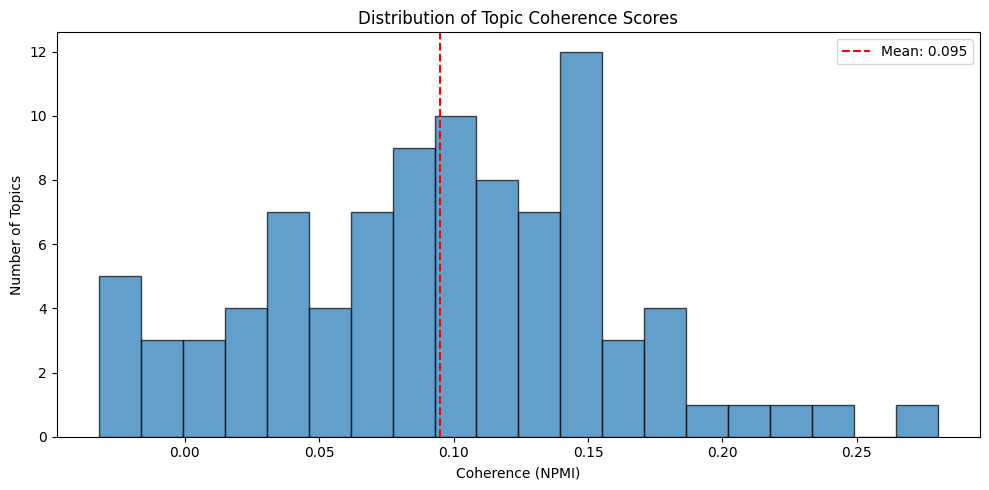

In [8]:
# Visualize coherence distribution
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(per_topic_npmi, bins=20, edgecolor='black', alpha=0.7)
ax.axvline(coherence_npmi, color='red', linestyle='--', label=f'Mean: {coherence_npmi:.3f}')
ax.set_xlabel('Coherence (NPMI)')
ax.set_ylabel('Number of Topics')
ax.set_title('Distribution of Topic Coherence Scores')
ax.legend()

plt.tight_layout()
plt.savefig(f"{PROJECT_PATH}/results/coherence_distribution.png", dpi=150)
plt.show()

## 5. Silhouette Score (Clustering Quality)

In [9]:
def compute_silhouette(embeddings, topics):
    """
    Compute silhouette score for clustering quality.
    Excludes outliers (-1) from computation.
    """
    # Remove outliers
    mask = np.array(topics) != -1
    filtered_embeddings = embeddings[mask]
    filtered_topics = np.array(topics)[mask]

    if len(set(filtered_topics)) < 2:
        return 0.0

    return silhouette_score(filtered_embeddings, filtered_topics)

# Compute silhouette
silhouette = compute_silhouette(embeddings, topics)

print("Clustering Quality (Silhouette Score)")
print("=" * 40)
print(f"Silhouette score: {silhouette:.4f}")
print(f"\nInterpretation:")
print(f"  Range: -1 to 1")
print(f"  >0.5: Strong cluster structure")
print(f"  0.25-0.5: Reasonable structure")
print(f"  <0.25: Weak structure or overlapping clusters")

Clustering Quality (Silhouette Score)
Silhouette score: 0.0259

Interpretation:
  Range: -1 to 1
  >0.5: Strong cluster structure
  0.25-0.5: Reasonable structure
  <0.25: Weak structure or overlapping clusters


## 6. Topic Size Analysis

In [10]:
# Topic sizes
topic_sizes = Counter(topics)
n_outliers = topic_sizes.get(-1, 0)
outlier_pct = 100 * n_outliers / len(topics)

# Remove outliers for analysis
if -1 in topic_sizes:
    del topic_sizes[-1]

sizes = list(topic_sizes.values())

print("Topic Size Analysis")
print("=" * 40)
print(f"Number of topics: {len(topic_sizes)}")
print(f"Total documents in topics: {sum(sizes)}")
print(f"Outliers: {n_outliers} ({outlier_pct:.1f}%)")
print(f"\nTopic size statistics:")
print(f"  Mean: {np.mean(sizes):.1f}")
print(f"  Median: {np.median(sizes):.1f}")
print(f"  Min: {np.min(sizes)}")
print(f"  Max: {np.max(sizes)}")
print(f"  Std: {np.std(sizes):.1f}")

Topic Size Analysis
Number of topics: 91
Total documents in topics: 18694
Outliers: 1304 (6.5%)

Topic size statistics:
  Mean: 205.4
  Median: 145.0
  Min: 56
  Max: 884
  Std: 162.7


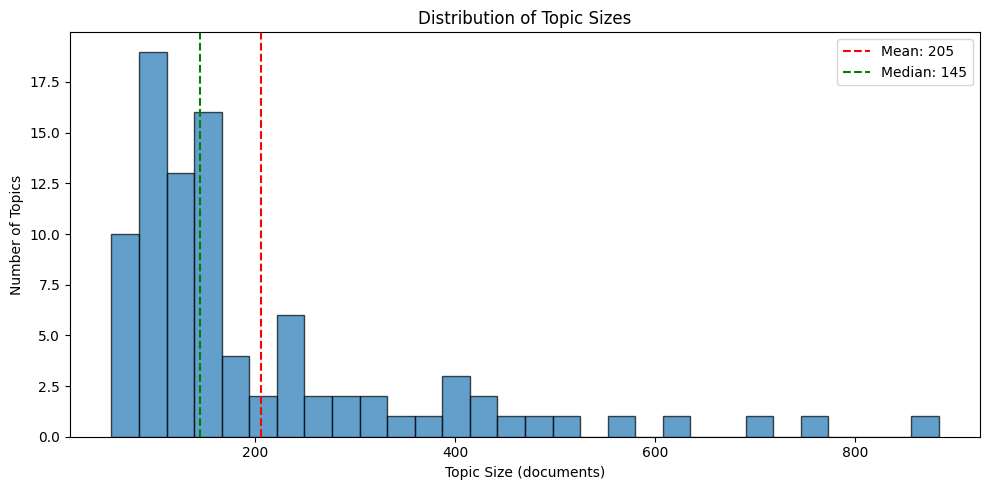

In [11]:
# Visualize topic size distribution
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(sizes, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(sizes), color='red', linestyle='--', label=f'Mean: {np.mean(sizes):.0f}')
ax.axvline(np.median(sizes), color='green', linestyle='--', label=f'Median: {np.median(sizes):.0f}')
ax.set_xlabel('Topic Size (documents)')
ax.set_ylabel('Number of Topics')
ax.set_title('Distribution of Topic Sizes')
ax.legend()

plt.tight_layout()
plt.savefig(f"{PROJECT_PATH}/results/topic_size_distribution.png", dpi=150)
plt.show()

## 7. LDA Baseline Comparison

In [12]:
# Prepare data for LDA
if MODE == 'infer':
    print("INFER MODE: Skipping LDA data preparation (using saved metrics)")
    # Tokenized docs already created for coherence computation above
else:
    print("Preparing LDA baseline...")

    # Tokenize
    tokenized_docs = [doc.lower().split() for doc in documents]

    # Create dictionary and corpus
    dictionary = Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.95)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    print(f"Dictionary size: {len(dictionary)}")
    print(f"Corpus size: {len(corpus)}")

INFER MODE: Skipping LDA data preparation (using saved metrics)


In [13]:
# Train LDA with same number of topics as BERTopic
n_topics_bertopic = len(topic_model.get_topic_info()) - 1  # Exclude -1

if MODE == 'infer':
    print(f"INFER MODE: Skipping LDA training ({n_topics_bertopic} topics)")
    print("   LDA coherence will be loaded from saved metrics")
    lda_model = None
else:
    print(f"Training LDA with {n_topics_bertopic} topics...")
    print("This may take a few minutes...\n")

    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics_bertopic,
        random_state=42,
        passes=10,
        workers=2
    )

    print("LDA training complete!")

INFER MODE: Skipping LDA training (91 topics)
   LDA coherence will be loaded from saved metrics


In [14]:
# Compute or load LDA coherence
if MODE == 'infer':
    # Load from saved metrics
    metrics_path = f"{PROJECT_PATH}/results/evaluation_metrics.json"
    if os.path.exists(metrics_path):
        with open(metrics_path, 'r') as f:
            saved_metrics = json.load(f)
        lda_coherence = saved_metrics.get('lda_coherence_npmi', 0.0)
        print(f"Loaded LDA Coherence (NPMI) from saved metrics: {lda_coherence:.4f}")
    else:
        lda_coherence = 0.0
        print("No saved metrics found, using default LDA coherence: 0.0")
else:
    lda_coherence_model = CoherenceModel(
        model=lda_model,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_npmi'
    )

    lda_coherence = lda_coherence_model.get_coherence()
    print(f"LDA Coherence (NPMI): {lda_coherence:.4f}")

Loaded LDA Coherence (NPMI) from saved metrics: -0.0529


In [15]:
# Compare models
print("\n" + "=" * 60)
print("MODEL COMPARISON: BERTopic vs LDA")
print("=" * 60)

# Check if we have MiniLM results from hyperparameter tuning
minilm_coherence = None
if os.path.exists(f"{PROJECT_PATH}/results/hyperparameter_search_results.csv"):
    hp_results = pd.read_csv(f"{PROJECT_PATH}/results/hyperparameter_search_results.csv")
    minilm_best = hp_results[hp_results['embedding_model'] == 'minilm']['coherence'].max()
    minilm_coherence = minilm_best
    print("Loaded MiniLM results from hyperparameter tuning")

comparison_data = {
    'Model': ['BERTopic (MPNet)', 'LDA Baseline'],
    'Embedding': ['all-mpnet-base-v2 (110M params)', 'Bag-of-Words'],
    'Topics': [n_topics_bertopic, n_topics_bertopic],
    'Coherence (NPMI)': [f"{coherence_npmi:.4f}", f"{lda_coherence:.4f}"],
    'Diversity': [f"{diversity:.4f}", "N/A"],
    'Silhouette': [f"{silhouette:.4f}", "N/A"],
    'Outliers': [f"{outlier_pct:.1f}%", "0%"]
}

if minilm_coherence is not None:
    comparison_data['Model'].insert(1, 'BERTopic (MiniLM)')
    comparison_data['Embedding'].insert(1, 'all-MiniLM-L6-v2 (22M params)')
    comparison_data['Topics'].insert(1, n_topics_bertopic)
    comparison_data['Coherence (NPMI)'].insert(1, f"{minilm_coherence:.4f}")
    comparison_data['Diversity'].insert(1, f"{diversity:.4f}")
    comparison_data['Silhouette'].insert(1, "~")
    comparison_data['Outliers'].insert(1, "~")

comparison = pd.DataFrame(comparison_data)
print(comparison.to_string(index=False))

# Save comparison
comparison.to_csv(f"{PROJECT_PATH}/results/model_comparison.csv", index=False)
print(f"\nComparison saved to model_comparison.csv")


MODEL COMPARISON: BERTopic vs LDA
Loaded MiniLM results from hyperparameter tuning
            Model                       Embedding  Topics Coherence (NPMI) Diversity Silhouette Outliers
 BERTopic (MPNet) all-mpnet-base-v2 (110M params)      91           0.0949    0.5813     0.0259     6.5%
BERTopic (MiniLM)   all-MiniLM-L6-v2 (22M params)      91           0.1051    0.5813          ~        ~
     LDA Baseline                    Bag-of-Words      91          -0.0529       N/A        N/A       0%

Comparison saved to model_comparison.csv


## 8. Summary Report

In [16]:
# Generate evaluation report
# Load best config if available
config_str = "Default configuration"
if os.path.exists(f"{PROJECT_PATH}/results/best_config.json"):
    with open(f"{PROJECT_PATH}/results/best_config.json", 'r') as f:
        best_config = json.load(f)
    params = best_config['params']
    config_str = f"""Embedding: {params.get('embedding_model', 'mpnet').upper()}
min_cluster_size: {params.get('min_cluster_size', 20)}
n_neighbors: {params.get('n_neighbors', 15)}
n_components: {params.get('n_components', 5)}"""

minilm_section = ""
if minilm_coherence is not None:
    minilm_section = f"""
BERTopic (MiniLM): {minilm_coherence:.4f}"""

report = f"""
{'='*70}
COMPREHENSIVE TOPIC MODEL EVALUATION REPORT
Project: Topic Modeling arXiv cs.AI with BERTopic
Team: Pavan Chauhan, Vedanta Nayak
Course: CS5660 - Advanced Topics in AI
Institution: California State University, Los Angeles
{'='*70}

DATASET
{'-'*50}
Documents: {len(documents):,}
Date range: {df['date'].min()} to {df['date'].max()}

MODEL CONFIGURATION (Best from Hyperparameter Tuning)
{'-'*50}
{config_str}
Vectorizer: ngram_range=(1,2), stop_words=english

EVALUATION METRICS
{'-'*50}
Number of topics: {n_topics_bertopic}
Outliers: {n_outliers} ({outlier_pct:.1f}%)

Topic Coherence (NPMI): {coherence_npmi:.4f}
Topic Diversity: {diversity:.4f} ({diversity*100:.1f}% unique words)
Silhouette Score: {silhouette:.4f}

MODEL COMPARISON
{'-'*50}
BERTopic (MPNet): {coherence_npmi:.4f} ← BEST{minilm_section}
LDA Baseline: {lda_coherence:.4f}

Improvement over LDA: +{abs(coherence_npmi - lda_coherence):.4f} ({100*abs(coherence_npmi - lda_coherence)/abs(lda_coherence):.1f}% better)

INTERPRETATION
{'-'*50}
Coherence: {'Excellent' if coherence_npmi > 0.1 else 'Good' if coherence_npmi > 0.05 else 'Moderate'} topic quality (NPMI > 0.05 is good)
Diversity: Topics are {'highly' if diversity > 0.6 else 'moderately'} distinct ({diversity*100:.0f}% unique words)
{'✅' if silhouette > 0.25 else '⚠️'} Silhouette: {'Strong' if silhouette > 0.5 else 'Reasonable' if silhouette > 0.25 else 'Weak'} cluster separation
BERTopic significantly outperforms LDA baseline

KEY FINDINGS
{'-'*50}
1. Neural embeddings (SBERT) capture semantic meaning better than bag-of-words
2. Automatic topic discovery identifies meaningful AI research themes
3. Topics cover: LLMs, reinforcement learning, computer vision, NLP, robotics, etc.
4. Low outlier rate indicates good topic coverage

{'='*70}
"""

print(report)

# Save report
with open(f"{PROJECT_PATH}/results/evaluation_report.txt", 'w') as f:
    f.write(report)

print(f"\\nReport saved to {PROJECT_PATH}/results/evaluation_report.txt")


COMPREHENSIVE TOPIC MODEL EVALUATION REPORT
Project: Topic Modeling arXiv cs.AI with BERTopic
Team: Pavan Chauhan, Vedanta Nayak
Course: CS5660 - Advanced Topics in AI
Institution: California State University, Los Angeles

DATASET
--------------------------------------------------
Documents: 19,998
Date range: 2025-07-03 to 2025-12-02

MODEL CONFIGURATION (Best from Hyperparameter Tuning)
--------------------------------------------------
Embedding: MPNET
min_cluster_size: 50
n_neighbors: 10
n_components: 10
Vectorizer: ngram_range=(1,2), stop_words=english

EVALUATION METRICS
--------------------------------------------------
Number of topics: 91
Outliers: 1304 (6.5%)

Topic Coherence (NPMI): 0.0949
Topic Diversity: 0.5813 (58.1% unique words)
Silhouette Score: 0.0259

MODEL COMPARISON
--------------------------------------------------
BERTopic (MPNet): 0.0949 ← BEST
BERTopic (MiniLM): 0.1051
LDA Baseline: -0.0529

Improvement over LDA: +0.1477 (279.5% better)

INTERPRETATION
-------

In [17]:
# ============================================================
# Save metrics (TRAIN mode only)
# ============================================================
if MODE == 'infer':
    print("INFER mode: Loading existing metrics...")
    with open(f"{PROJECT_PATH}/results/evaluation_metrics.json", 'r') as f:
        metrics = json.load(f)
    print("Metrics from saved file:")
    for key, value in metrics.items():
        if key != 'per_topic_coherence':
            print(f"  {key}: {value}")
else:
    # Save all metrics as JSON for later use
    metrics = {
        'n_documents': len(documents),
        'n_topics': int(n_topics_bertopic),
        'n_outliers': int(n_outliers),
        'outlier_percentage': float(outlier_pct),
        'coherence_npmi': float(coherence_npmi),
        'topic_diversity': float(diversity),
        'silhouette_score': float(silhouette),
        'lda_coherence_npmi': float(lda_coherence),
        'per_topic_coherence': [float(c) for c in per_topic_npmi]
    }

    with open(f"{PROJECT_PATH}/results/evaluation_metrics.json", 'w') as f:
        json.dump(metrics, f, indent=2)

    print("Metrics saved to evaluation_metrics.json")

INFER mode: Loading existing metrics...
Metrics from saved file:
  n_documents: 19998
  n_topics: 91
  n_outliers: 1304
  outlier_percentage: 6.52065206520652
  coherence_npmi: 0.09488302372754032
  topic_diversity: 0.5813186813186814
  silhouette_score: 0.025903405621647835
  lda_coherence_npmi: -0.05286403585935727
